In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("C:/guided_proj_3/troop_movements.csv", index_col=False)

df2 = df.groupby(['empire_or_resistance']).size()

info = [['empire',df2[0]], ['resistance',df2[1]]]
empireResistanceDf = pd.DataFrame(info, columns = ['empire_or_resistance', 'count'])
empireResistanceDf


,empire_or_resistance,count
0,empire,601
1,resistance,399


In [2]:
df2 = df.groupby(['homeworld'])['homeworld'].count()
df2 = df2.to_frame()
df2 = df2.rename(columns={"homeworld": "Homeworld", "homeworld":"count"})
df2 = df2.reset_index()
df2

,homeworld,count
0,Alderaan,28
1,Aleen Minor,32
2,Bestine IV,28
3,Cerea,26
4,Champala,26
5,Chandrila,21
6,Concord Dawn,25
7,Corellia,23
8,Dagobah,15
9,Dathomir,33


In [3]:
df2 = df.groupby(['unit_type'])['unit_type'].count()
df2 = df2.to_frame()
df2 = df2.rename(columns={"unit_type": "Unit_type", "unit_type":"count"})
df2 = df2.reset_index()
df2

,unit_type,count
0,at-at,124
1,at-st,108
2,resistance_soldier,110
3,stormtrooper,134
4,tauntaun,96
5,tie_fighter,114
6,tie_silencer,121
7,unknown,103
8,x-wing,90


In [4]:
df['is_resistance'] = np.where(df['empire_or_resistance'] == 'resistance', 'True', 'False')
df

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2023-07-11 15:54:09,1,resistance_soldier,resistance,5,10,10,6,Tholoth,True
1,2023-07-11 15:54:08,2,tie_silencer,empire,4,6,5,3,Ojom,False
2,2023-07-11 15:54:07,3,tie_silencer,empire,8,6,7,9,Kalee,False
3,2023-07-11 15:54:06,4,resistance_soldier,resistance,10,6,4,10,Troiken,True
4,2023-07-11 15:54:05,5,tie_fighter,empire,8,6,5,4,Haruun Kal,False
...,...,...,...,...,...,...,...,...,...,...
995,2023-07-11 15:37:34,996,x-wing,resistance,5,9,10,4,Umbara,True
996,2023-07-11 15:37:33,997,resistance_soldier,resistance,6,7,3,3,Dagobah,True
997,2023-07-11 15:37:32,998,stormtrooper,empire,8,2,10,10,Eriadu,False
998,2023-07-11 15:37:31,999,tie_fighter,empire,5,6,1,2,Dathomir,False


<Axes: xlabel='empire_or_resistance', ylabel='count'>

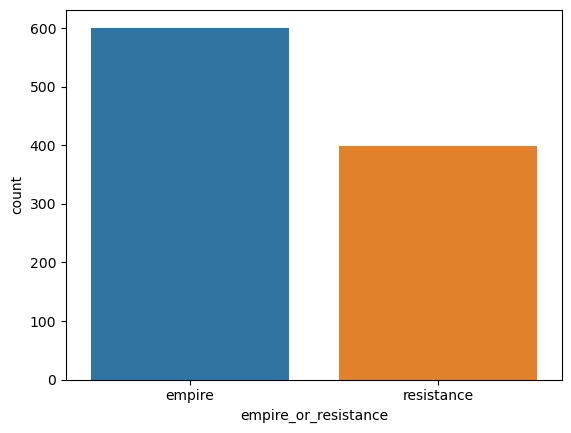

In [5]:
sns.barplot(data=empireResistanceDf, x="empire_or_resistance", y="count")

In [44]:
# df_dummies = pd.get_dummies(df.homeworld, df.unit_type)
df_dummies = pd.get_dummies(data=df[['homeworld', 'unit_type']], columns=['homeworld', 'unit_type'])
print(df_dummies.columns)
#print(df_dummies)
X = df_dummies
y = df['is_resistance']

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Index(['homeworld_Alderaan', 'homeworld_Aleen Minor', 'homeworld_Bestine IV',
       'homeworld_Cerea', 'homeworld_Champala', 'homeworld_Chandrila',
       'homeworld_Concord Dawn', 'homeworld_Corellia', 'homeworld_Dagobah',
       'homeworld_Dathomir', 'homeworld_Dorin', 'homeworld_Eriadu',
       'homeworld_Glee Anselm', 'homeworld_Haruun Kal', 'homeworld_Iktotch',
       'homeworld_Iridonia', 'homeworld_Kalee', 'homeworld_Kashyyyk',
       'homeworld_Malastare', 'homeworld_Mirial', 'homeworld_Mon Cala',
       'homeworld_Muunilinst', 'homeworld_Naboo', 'homeworld_Ojom',
       'homeworld_Quermia', 'homeworld_Rodia', 'homeworld_Ryloth',
       'homeworld_Serenno', 'homeworld_Shili', 'homeworld_Skako',
       'homeworld_Socorro', 'homeworld_Stewjon', 'homeworld_Sullust',
       'homeworld_Tatooine', 'homeworld_Tholoth', 'homeworld_Toydaria',
       'homeworld_Trandosha', 'homeworld_Troiken', 'homeworld_Tund',
       'homeworld_Umbara', 'homeworld_Vulpter', 'homeworld_Zolan',
       'u

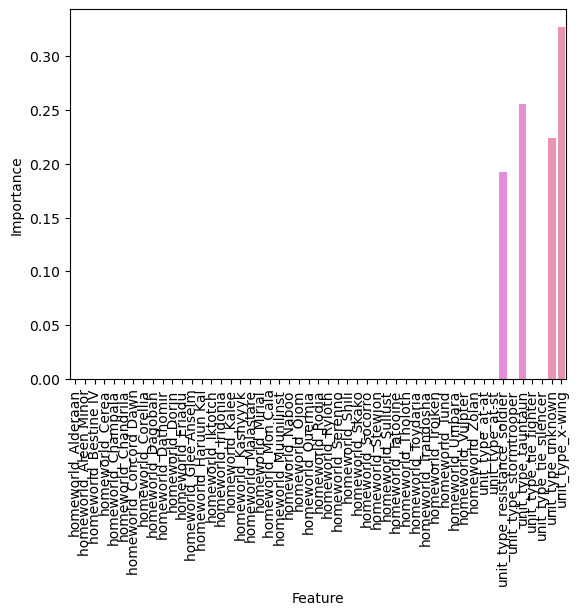

In [47]:
# Get feature importances
importances = clf.feature_importances_


# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': df_dummies.columns, 'Importance': importances})

#feature_importances
barPlot = sns.barplot(data=feature_importances, x="Feature", y="Importance")
for item in barPlot.get_xticklabels():
    item.set_rotation(90)
